Setting up the colab enviornment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"


In [ ]:
import findspark
findspark.init()

import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import unix_timestamp, concat, lit, col
from pyspark.sql.functions import avg, substring, count, size, explode, array, expr
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
data = spark.read.csv('combined_data.csv', header=True, inferSchema=True)
data = data.limit(50000)
# Inspect the data
data.show(5)
print(data.columns)

+----------+----------+-------------+-------------+-------------+-----------+------+-------+---------+---------------+--------+--------------------+----------------------+-----------------------+----+--------------------+---------+-----+--------+---------+---------+----+------------+-------+-----+-------+---------+-----+-----+-------+-------+-----+-----+-----+------------+------+-------------+----+----+--------------+-------------------+------+-----+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+------+------+---------------+------------+------------+---------------+-----------------+-----------------+-------+---------+---------+---------+---------+---------+---------+---------+---------+-------------+-----------------------------+-------------------------------+----------+----------+-----------+---------+------------------+-------------+------------+---------------+----------+----------+---------+---------+---------------+---

In [ ]:
from pyspark.sql.functions import col, when, count, isnan

# Cache the data for faster repeated operations
data.cache()

# Calculate total row count once
total_count = data.count()

# Separate numeric and non-numeric columns
numeric_columns = [c for c, t in data.dtypes if t in ("int", "double", "float")]
non_numeric_columns = [c for c, t in data.dtypes if t not in ("int", "double", "float")]

# Calculate missing percentages for numeric columns (isNull + isnan)
numeric_missing_counts = [
    (count(when(col(c).isNull() | isnan(c), c)) / total_count).alias(c)
    for c in numeric_columns
]

# Calculate missing percentages for non-numeric columns (isNull only)
non_numeric_missing_counts = [
    (count(when(col(c).isNull(), c)) / total_count).alias(c)
    for c in non_numeric_columns
]

# Combine both lists
missing_counts = data.select(*numeric_missing_counts, *non_numeric_missing_counts)

# Show the missing value percentages
missing_counts.show()


+-------------+-------------+-------------+------+-------+------+------------+-----+-------+---------+------+------+-------+-------+-------+------+-------+------------+------+------+------+------+------+------+------+------+------+------+------+---------------+------------+------------+---------------+-----------------+-----------------+-------+---------+---------+---------+---------+---------+---------+---------+---------+-------------+-----------------------------+-------------------------------+----------+----------+-----------+---------+------------------+-------------+------------+----------+----------+---------+---------+---------------+---------------+--------------+--------------+---------+------------------+-------------+------------------------------+---------------------+-----------+---------------+--------------+------------+-----------+--------------+--------------+-------+-------+-------------------+--------------------------------+----------------------------+-----------

In [ ]:
# Calculate percentage of missing values per column
missing_percentage = data.select(
    *[
        (count(when(col(c).isNull() | isnan(c), c)) / data.count()).alias(c)
        for c in data.columns
    ]
)

# Find columns with >50% missing values
high_nan_columns = [
    c for c, v in missing_percentage.first().asDict().items() if v > 0.5
]

print(f"Columns with >50% missing values: {high_nan_columns}")

# Drop columns with 100% missing values or high NaNs
# data = data.drop(*high_nan_columns)


In [ ]:
# Fill missing values based on column types
data = data.fillna(
    {c: "UNKNOWN" for c, t in data.dtypes if t == "string"}  # Replace missing strings
).fillna(
    {c: -1 for c, t in data.dtypes if t in ["int", "double"]}  # Replace missing numerics
)


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Define lagged columns and the number of lags
lagged_columns = [
    'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
    'events', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'spin_axis',
    'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle'
]

# Create lagged features
window_spec = Window.partitionBy('game_pk').orderBy('at_bat_number')
for col_name in lagged_columns:
    for lag_step in range(1, 4):  # Create 3 lags
        lag_col = f"{col_name}_lag_{lag_step}"
        data = data.withColumn(lag_col, lag(col_name, lag_step).over(window_spec))

# Show a sample of the data with lagged features
data.show(5)


+----------+----------+-------------+-------------+-------------+------------------+------+-------+---------+-------------+--------+--------------------+----------------------+-----------------------+----+--------------------+---------+-----+--------+---------+---------+----+------------+-----------+-----+-------+---------+-----+-----+-------+-------+-----+-----+-----+------------+------+-------------+------+------+--------------+-------------------+-------+-------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+------+------+---------------+------------+------------+---------------+-----------------+-----------------+-------+---------+---------+---------+---------+---------+---------+---------+---------+-------------+-----------------------------+-------------------------------+----------+----------+-----------+---------+------------------+-------------+------------+---------------+----------+----------+---------+---------+----

In [ ]:
# Drop rows with any missing values
data = data.dropna()


In [ ]:
from pyspark.ml.feature import StringIndexer

# Identify non-numerical columns
non_numerical_columns = [c for c, t in data.dtypes if t == "string"]
print(f"Non-numerical columns: {non_numerical_columns}")

# Apply StringIndexer to each non-numerical column
for col_name in non_numerical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    data = indexer.fit(data).transform(data)

# Drop original categorical columns if not needed
data = data.drop(*non_numerical_columns)
data.show(5)


Non-numerical columns: ['pitch_type', 'game_date', 'player_name', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'pitch_name', 'if_fielding_alignment', 'of_fielding_alignment', 'bat_speed', 'swing_length', 'pitch_type_lag_1', 'pitch_type_lag_2', 'pitch_type_lag_3', 'events_lag_1', 'events_lag_2', 'events_lag_3']


KeyboardInterrupt: 

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import time

# Define the lagged feature creation function
def create_lagged_features_spark(data, lagged_columns, lags=3):
    window_spec = Window.partitionBy('game_pk').orderBy('at_bat_number')
    for col_name in lagged_columns:
        for lag_step in range(1, lags + 1):
            lag_col = f"{col_name}_lag_{lag_step}"
            data = data.withColumn(lag_col, F.lag(col_name, lag_step).over(window_spec))
    return data

# List of lagged columns
lagged_columns = ['pitch_type', 'release_speed', 'release_pos_x']

# Benchmark performance for different numbers of partitions (scaling proxy)
results = []
for num_partitions in [2, 4, 8, 16, 32]:  # Example: Change partition counts
    data_repartitioned = data.repartition(num_partitions)

    start_time = time.time()
    lagged_data = create_lagged_features_spark(data_repartitioned, lagged_columns, lags=3)
    lagged_data.count()  # Trigger execution
    elapsed_time = time.time() - start_time

    results.append((num_partitions, elapsed_time))
    print(f"Partitions: {num_partitions}, Time: {elapsed_time:.2f} seconds")


Partitions: 2, Time: 4.06 seconds
Partitions: 4, Time: 1.24 seconds
Partitions: 8, Time: 1.73 seconds
Partitions: 16, Time: 1.37 seconds
Partitions: 32, Time: 1.66 seconds


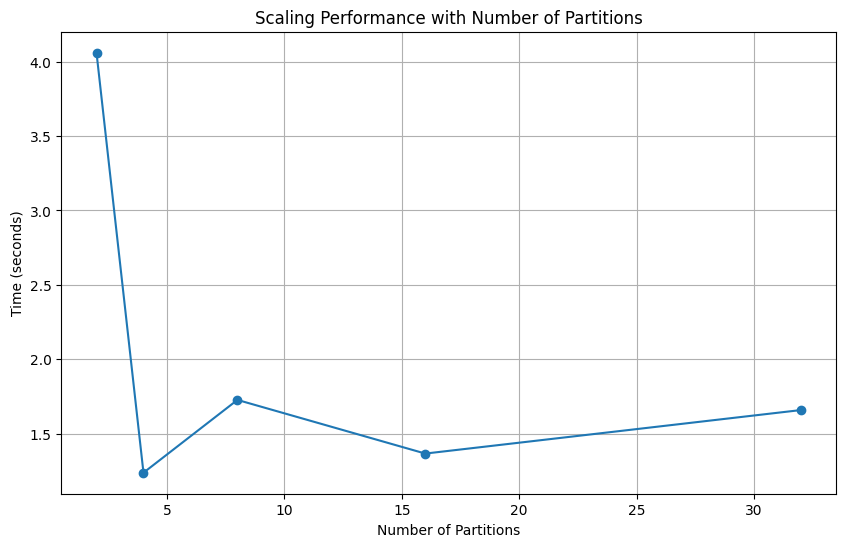

In [ ]:
import matplotlib.pyplot as plt

# Extract results for plotting
partitions, times = zip(*results)

plt.figure(figsize=(10, 6))
plt.plot(partitions, times, marker='o')
plt.title("Scaling Performance with Number of Partitions")
plt.xlabel("Number of Partitions")
plt.ylabel("Time (seconds)")
plt.grid()
plt.show()
